In [25]:
import pandas

In [36]:
def get_condition(row):
    
    even = not (row.subject_id % 2)
    
    if row.subject_id == 0:
        even = False
    
    if np.isnan(row['syncvalue[SubTrial]']):
        return np.nan
    
#     print row
    
    if even:
        return {11:'cs-', 12:'cs+', 14:'cs+', np.nan:np.nan}[row['syncvalue[SubTrial]']]
    else:
        return {11:'cs+', 12:'cs-', 13:'cs+', np.nan:np.nan}[row['syncvalue[SubTrial]']]
    

In [37]:
df = pandas.read_excel('/home/gdholla1/data/daphne/behavior/Task2_All Participants.xlsx')
df.ix[df.Subject == 'P05', 'subject'] = 0

df['onset'] = df['face3sec.OnsetTime'] - df['Waitforscanner1c.RTTime']
df['onset'] /= 1000

# df['condition'] = df['syncvalue[SubTrial]']

# df['condition'] = df['condition'].map({11:'cs+', 12:'cs-', 13:'shock'})

df.ix[df.Subject == 'P05', 'Subject'] = 0

df['subject_id'] = df.Subject.astype(int)

df['condition'] = df.apply(get_condition, 1)

In [38]:
df.groupby(['subject_id', 'condition']).size()

subject_id  condition
0           cs+          12
            cs-          12
1           cs+          12
            cs-          12
2           cs+          12
            cs-          12
3           cs+          12
            cs-          12
4           cs+          12
            cs-          12
6           cs+          12
            cs-          12
7           cs+          12
            cs-          12
8           cs+          12
            cs-          12
9           cs+          18
            cs-          12
11          cs+          12
            cs-          12
13          cs+          12
            cs-          12
16          cs+          12
            cs-          12
dtype: int64

In [39]:
df.to_pickle('/home/gdholla1/data/daphne/behavior/all_data2.pandas')

In [40]:
import pyfir

In [41]:
def get_signal(subject_id, mask, mask_type='disjunct', interpolation='nearestneighbour', phys_filtered=False):

    if interpolation  == 'weighted':
        signal = np.loadtxt('/home/gdholla1/data/daphne/registration/extracted_signal_weighted/_mask_%s_subject_id_S%02d/_interp_trilinear/_extract_weighted_phys1/run2_maths_maths_maths_dtype_mcf_mask_gms_tempfilt_regfilt_maths_weighted.txt' % (mask, subject_id))
    else:
        if phys_filtered:
            signal = np.loadtxt('/home/gdholla1/data/daphne/registration/extracted_signal_%s/phys_filtered/_mask_%s_subject_id_S%02d/_interp_%s/_extract_signal_phys_%s1/run2_maths_maths_maths_dtype_mcf_mask_gms_tempfilt_regfilt_maths_ts.txt' % (mask_type, mask, subject_id, interpolation, mask_type))
        else:
            signal = np.loadtxt('/home/gdholla1/data/daphne/registration/extracted_signal_%s/_mask_%s_subject_id_S%02d/_interp_%s/_extract_signal_%s0/run2_dtype_mcf_mask_gms_tempfilt_regfilt_maths_ts.txt' % (mask_type, mask, subject_id, interpolation, mask_type))
    
    signal = (signal / signal.mean()) * 100
    signal -= signal.mean()
    
    return signal

In [42]:
def get_onsets(subject_id):
    df = pandas.read_pickle('/home/gdholla1/data/daphne/behavior/all_data2.pandas')
    
    df = df[df.Subject == subject_id]
    
    onsets = {'cs+':df[df.condition == 'cs+'].onset.tolist(),
              'cs-':df[df.condition == 'cs-'].onset.tolist(),
              'shock':df[df.condition == 'shock'].onset.tolist()}
    
    return onsets
    
    
    

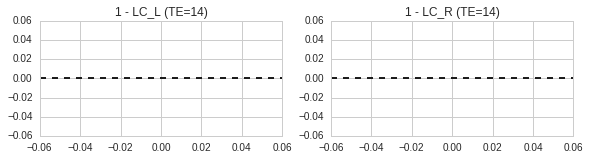

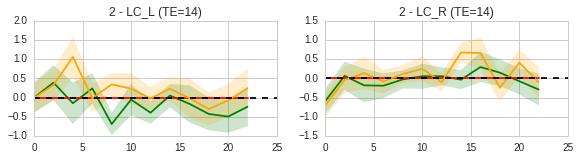

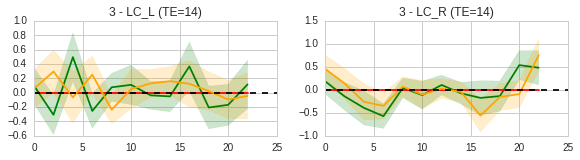

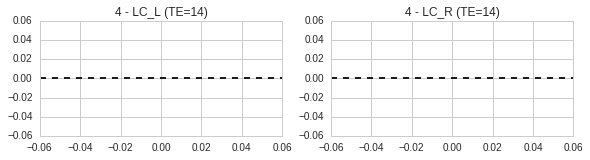

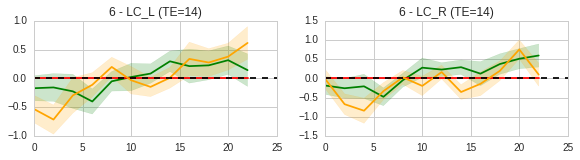

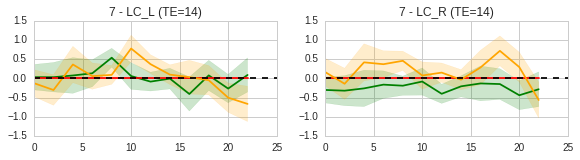

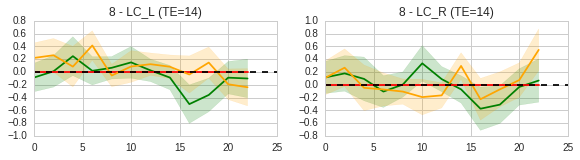

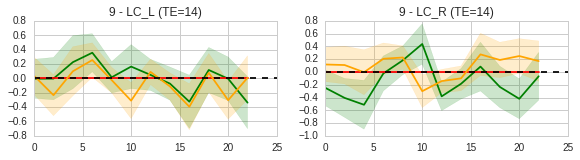

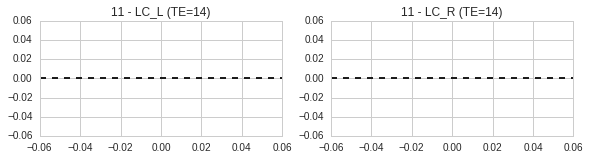

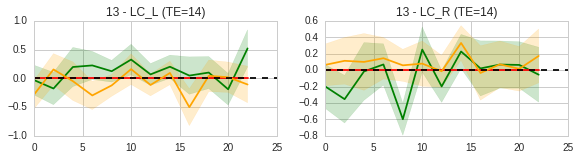

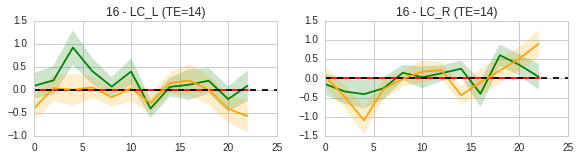

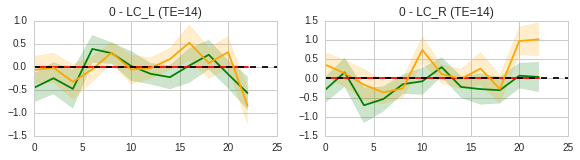

In [43]:
firs = []

for subject_id in df.subject_id.unique():
    plt.figure(figsize=(20, 7))
    for i, mask in enumerate(['LC_L', 'LC_R']):
        
        try:
            signal = get_signal(subject_id, mask, interpolation='weighted', mask_type='disjunct', phys_filtered=False)
            onsets = get_onsets(subject_id)


            if onsets:
                fir = pyfir.FIR(signal)
                r = fir.fit(onsets, 1.2, resolution = 2, len_impulse=25)

                plt.subplot(3, 4, i+1)
                plt.title('%s - %s (TE=14)' % (subject_id, mask))
                r.plot_results({'shock':'red',
                                'cs+':'orange',
                                'cs-':'green',})
                #plt.ylim(-1, 1)

                if i != 7:
                    plt.gca().legend_.remove()

                for condition, hrf in zip(r.conditions, r.beta):
                    for time, value in zip(r.times, hrf):
                        firs.append({'mask':mask,
                                     'subject_id':subject_id,
                                     'condition':condition,
                                     't':time,
                                     'value':value})


        except Exception as e:
            print 'Error with %s/%s - %s' % (subject_id, mask, e)

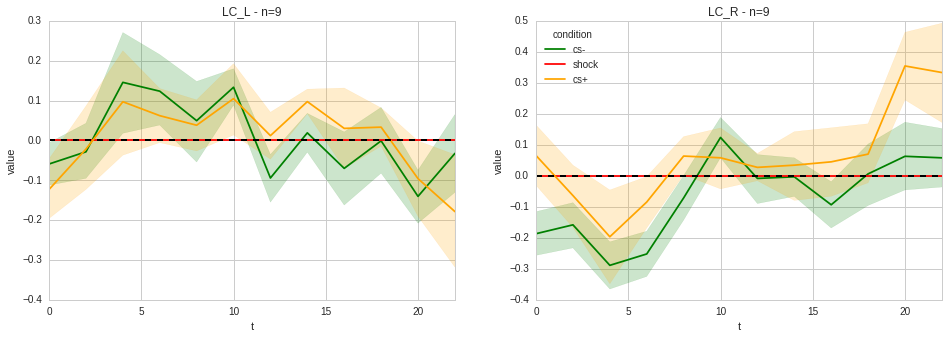

In [44]:
df_firs = pandas.DataFrame(firs)
df_firs = df_firs[~df_firs.value.isnull()]
sns.set_palette(['green', 'red','orange', ])
plt.figure(figsize=(16, 5))

sns.set_style('whitegrid')


# for i, ((te, mask), d) in enumerate(df_firs.groupby(['TE', 'mask'], sort=False)):

# yticks = np.arange(-0.3, 0.51, .1).round(1)

for i, mask in enumerate(['LC_L', 'LC_R']):
    plt.subplot(1, 2, i+1)
#     plt.ylim(-.3, .5)
    sns.tsplot(df_firs[(df_firs['mask'] == mask)], unit='subject_id', time='t', value='value', condition='condition', ci=67)
    
    if i != 1:
        plt.gca().legend_.remove()
        
    plt.title('%s - n=%d' % (mask, df_firs[(df_firs['mask'] == mask)].subject_id.unique().shape[0]))
    plt.axhline(0, lw=2, ls='--', c='k')
    
#     if i < 5:
#         plt.xticks(plt.xticks()[0], [''] * len(plt.xticks()[0]))
#         plt.xlabel('')
#     else:
#         plt.xlabel('t (s)')
        
#     if i % 5 == 0:
#         plt.ylabel('% signal change')
        
#         plt.yticks(yticks, yticks)
#     else:
#         plt.yticks(yticks, [''] * len(yticks))
#         plt.ylabel('')
    
# plt.suptitle('Mean signal over all %s subjects' % df_firs.subject_id.unique().shape, fontsize=24)

plt.savefig('all_nuclei.pdf', transparent=True)

In [349]:
df_firs.groupby(['mask', 'subject_id']).size()

mask  subject_id
LC_L  0             39
      2             39
      3             39
      6             39
      7             39
      8             39
      9             39
      16            39
LC_R  0             39
      1             39
      2             39
      3             39
      6             39
      7             39
      8             39
      9             39
      13            39
      16            39
dtype: int64

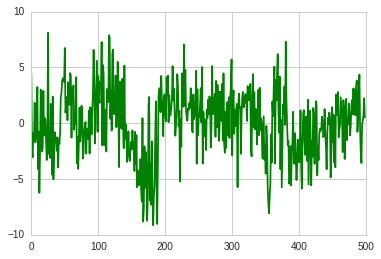

In [310]:
plt.plot(get_signal(7, 'LC_L'))

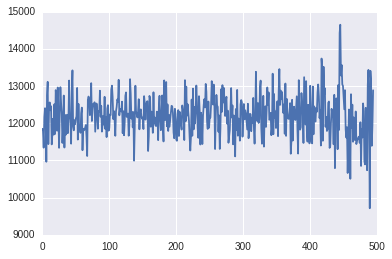

In [74]:
signal = np.loadtxt('/home/gdholla1/data/daphne/registration/extracted_signal_disjunct/_mask_LC_R_subject_id_S01/_interp_nearestneighbour/_extract_signal_disjunct0/run1_dtype_mcf_mask_gms_tempfilt_regfilt_maths_ts.txt')
signal = np.loadtxt('/home/gdholla1/data/daphne/preprocess_phys/motion_regressors_filtered_files/_subject_id_S02/_fwhm_0.0/_addmean0/run1_maths_maths_maths_dtype_mcf_mask_gms_tempfilt_regfilt_maths.nii.gz')
plt.plot(signal)



In [131]:
fir = pyfir.FIR(signal)

In [132]:
onsets = {'cs+':df[df.condition == 'cs+'].onset.tolist(),
          'cs-':df[df.condition == 'cs-'].onset.tolist(),
          'shock':df[df.condition == 'shock'].onset.tolist()}

In [133]:
r = fir.fit(onsets, 1.2, resolution=1.2, len_impulse=20)

In [136]:
r.times

array([  0. ,   1.2,   2.4,   3.6,   4.8,   6. ,   7.2,   8.4,   9.6,
        10.8,  12. ,  13.2,  14.4,  15.6,  16.8,  18. ,  19.2])

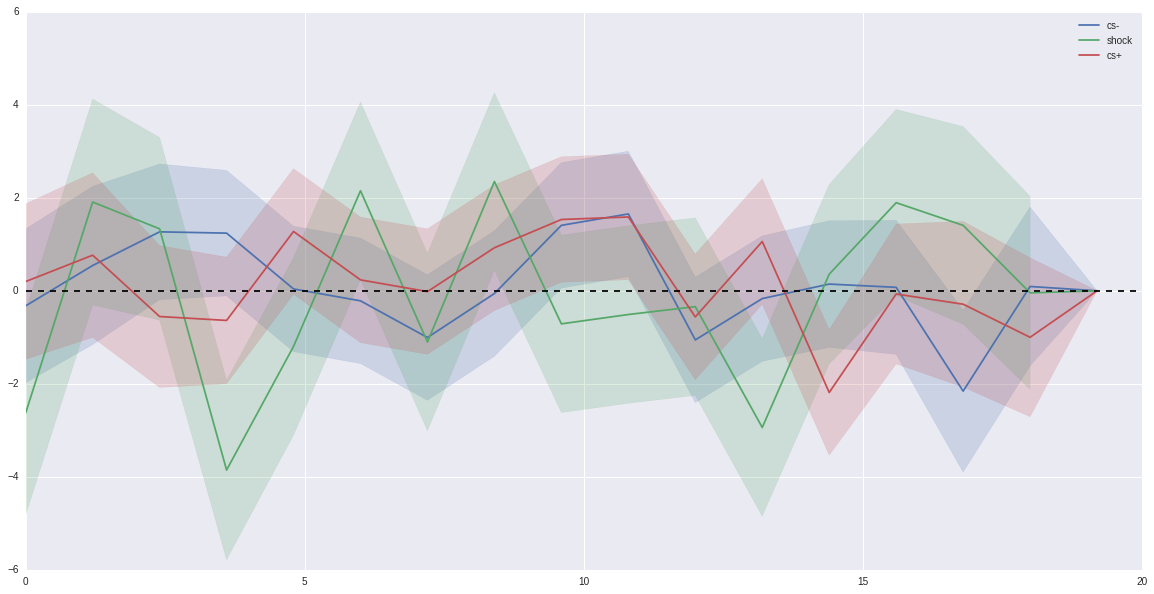

In [83]:
plt.gcf().set_size_inches((20, 10))
r.plot_results()